In [1]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from keras.layers import Input
import os
import pandas as pd
import numpy as np
import pydicom
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB3
from tqdm import tqdm
import warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import random

warnings.filterwarnings("ignore", category=UserWarning, module="pydicom")

In [4]:
# Rutas a los directorios
train_dir = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/train'
test_dir = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/test'
train_csv = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/train.csv'
sample_submission_csv = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/sample_submission.csv'

# Cargar los datos de entrenamiento
train_df = pd.read_csv(train_csv)

# Visualizar algunas filas del DataFrame
train_df.head(10)

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10062189329714053601...,14
1,1.2.826.0.1.3680043.8.498.53411283183733547704...,3
2,1.2.826.0.1.3680043.8.498.12955484645689261949...,3
3,1.2.826.0.1.3680043.8.498.10408703585974384892...,3
4,1.2.826.0.1.3680043.8.498.30255106562321206269...,9
5,1.2.826.0.1.3680043.8.498.80404681981834387091...,0
6,1.2.826.0.1.3680043.8.498.16743022096024694044...,2
7,1.2.826.0.1.3680043.8.498.33303514480609398517...,2
8,1.2.826.0.1.3680043.8.498.15144815417970827102...,13
9,1.2.826.0.1.3680043.8.498.19878644487806502082...,3


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278 entries, 0 to 1277
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SOPInstanceUID  1278 non-null   object
 1   Target          1278 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.1+ KB


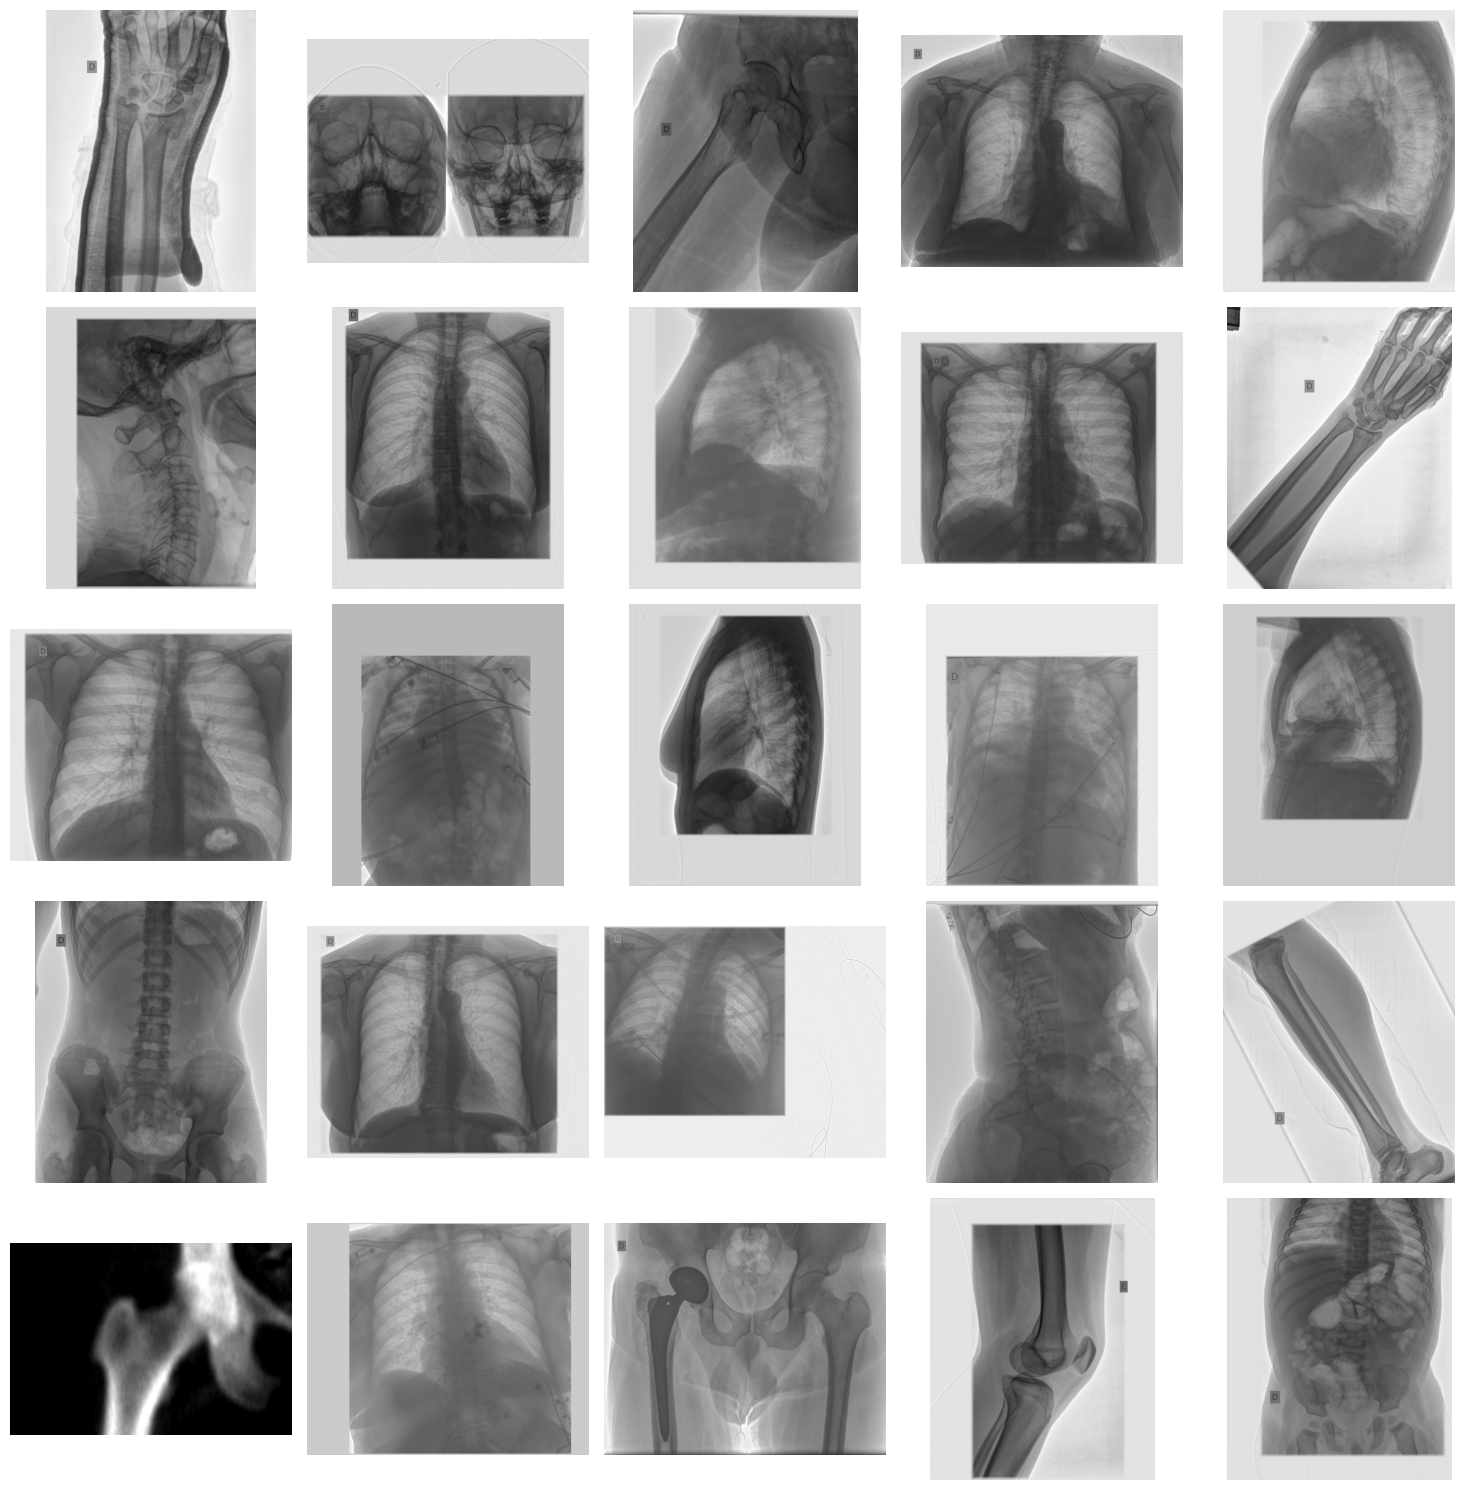

In [9]:
def show_dicom_image_multi(file_path, ax):
    dicom = pydicom.dcmread(file_path)
    ax.imshow(dicom.pixel_array, cmap='gray')
    ax.axis('off')  # Desactivar ejes

# Seleccionar 25 imágenes al azar
random_indices = random.sample(range(len(train_df)), 25)
random_image_paths = [os.path.join(train_dir, train_df.iloc[i]['SOPInstanceUID'] + '.dcm') for i in random_indices]

# Crear una figura y ejes para una matriz de 5x5
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

# Mostrar cada imagen en su correspondiente subgráfico
for ax, image_path in zip(axes.flat, random_image_paths):
    show_dicom_image_multi(image_path, ax)

# Ajustar el espacio entre subgráficos
plt.tight_layout()
plt.show()


Referencia: 1.2.826.0.1.3680043.8.498.75932240489221075589097397484896361550.dcm


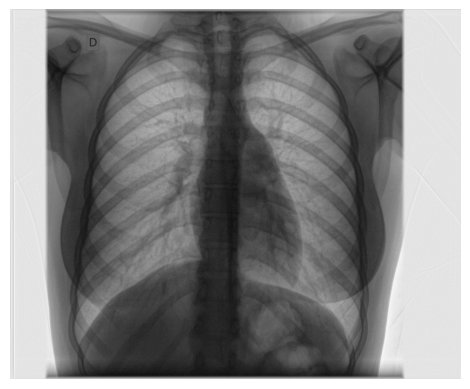

Referencia: 1.2.826.0.1.3680043.8.498.80518330963406833915089209886834390159.dcm


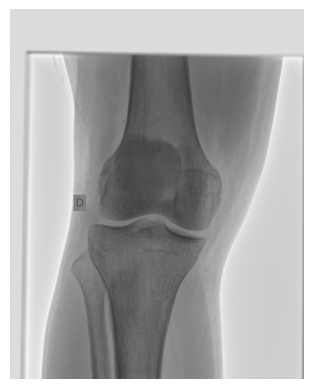

Referencia: 1.2.826.0.1.3680043.8.498.97413731471864060627365739417678218380.dcm


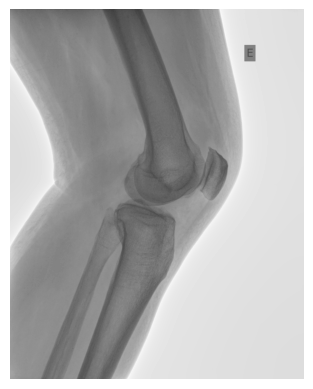

Referencia: 1.2.826.0.1.3680043.8.498.98229201581139590153090960568103270985.dcm


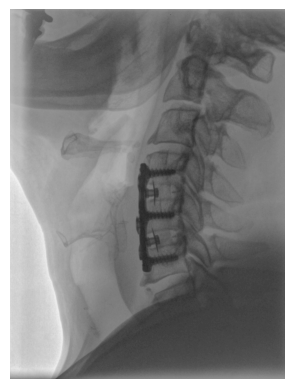

Referencia: 1.2.826.0.1.3680043.8.498.84551354213532970228348448377009898172.dcm


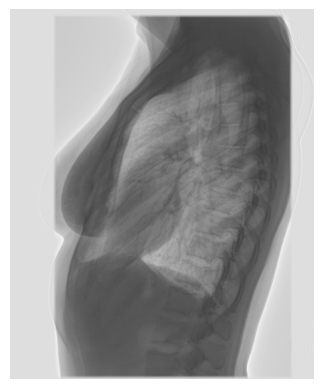

In [ ]:
import os
import pydicom
import matplotlib.pyplot as plt

# Nuevas referencias
nuevas_referencias = [
    '1.2.826.0.1.3680043.8.498.75932240489221075589097397484896361550.dcm',
    '1.2.826.0.1.3680043.8.498.80518330963406833915089209886834390159.dcm',
    '1.2.826.0.1.3680043.8.498.97413731471864060627365739417678218380.dcm',
    '1.2.826.0.1.3680043.8.498.98229201581139590153090960568103270985.dcm',
    '1.2.826.0.1.3680043.8.498.84551354213532970228348448377009898172.dcm'
]

# Función para mostrar una imagen DICOM
def mostrar_imagen(dicom_path):
    dicom = pydicom.dcmread(dicom_path)
    plt.imshow(dicom.pixel_array, cmap='gray')
    plt.axis('off')
    plt.show()

# Mostrar las imágenes correspondientes a las nuevas referencias especificadas
for referencia in nuevas_referencias:
    imagen_path = os.path.join(test_dir, referencia)
    print(f"Referencia: {referencia}")
    mostrar_imagen(imagen_path)


Paso 1: Leer y preprocesar las imágenes DICOM
Vamos a convertir las imágenes DICOM en arrays de píxeles.

In [7]:
#Numero maximo de imagenes para entrenar el modelo
max = 5

In [8]:
#Numero maximo de imagenes para entrenar el modelo
def preprocess_image_2c(file_path, img_size):
    dicom = pydicom.dcmread(file_path)
    img = dicom.pixel_array
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # Normalización
    return img

def preprocess_image(file_path, img_size):
    # Leer el archivo DICOM
    dicom = pydicom.dcmread(file_path)
    img = dicom.pixel_array

    # Normalizar y escalar los píxeles
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = cv2.convertScaleAbs(img)
    cv2.imwrite(output_path, img)

    return img


In [15]:
import os
import pydicom
import cv2
import numpy as np
from io import BytesIO
from tqdm import tqdm

def convert_dicom_to_png(dicom_bytes, output_path):
    ds = pydicom.dcmread(BytesIO(dicom_bytes))
    img = ds.pixel_array
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img= cv2.resize(img, (255, 255))
    img = cv2.convertScaleAbs(img)
    cv2.imwrite(output_path, img)

# Ruta de la carpeta de origen
train_dir = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/train'

# Ruta de la carpeta de destino
output_dir = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/processed_images_train_5'

# Crear la carpeta de destino si no existe
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Determinar el número máximo de imágenes a procesar
max_images = max

# Obtener todos los archivos DICOM en la carpeta de origen
dicom_files = [f for f in os.listdir(train_dir) if f.endswith('.dcm')]

# Limitar el número de archivos a procesar
dicom_files = dicom_files[:max_images]

# Procesar los archivos con una barra de progreso
for filename in tqdm(dicom_files, desc="Procesando imágenes"):
    dicom_path = os.path.join(train_dir, filename)

    # Leer los bytes del archivo DICOM
    with open(dicom_path, 'rb') as f:
        dicom_bytes = f.read()

    # Generar la ruta de salida para el archivo PNG
    output_path = os.path.join(output_dir, os.path.splitext(filename)[0] + '.png')

    # Convertir DICOM a PNG y guardar
    convert_dicom_to_png(dicom_bytes, output_path)

print('Conversión completada.')


Procesando imágenes: 100%|██████████| 5/5 [00:23<00:00,  4.79s/it]

Conversión completada.


In [16]:
import os
import cv2

# Directorio donde se encuentran las imágenes
input_dir = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/processed_images_train_5'

# Listar archivos en el directorio
files = os.listdir(input_dir)

# Elegir una muestra de imágenes para el análisis
num_samples = 5
sample_files = files[:num_samples]

# Iterar sobre las imágenes de la muestra
for filename in sample_files:
    # Ruta completa de la imagen
    img_path = os.path.join(input_dir, filename)

    # Cargar la imagen
    img = cv2.imread(img_path)

    # Ver la forma de la imagen (alto, ancho, canales)
    print(f"Imagen: {filename}, Shape: {img.shape}")

    # Ver el número de canales de la imagen
    if len(img.shape) == 3:
        channels = "RGB"
    elif len(img.shape) == 2:
        channels = "Grayscale"
    print(f"Número de canales de {filename}: {channels}")

    # Mostrar la imagen (opcional)
    # cv2.imshow('Imagen', img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()


Imagen: 1.2.826.0.1.3680043.8.498.12321430148353134437369943500506682108.png, Shape: (255, 255, 3)
Número de canales de 1.2.826.0.1.3680043.8.498.12321430148353134437369943500506682108.png: RGB
Imagen: 1.2.826.0.1.3680043.8.498.12336783553322800699204939523033613595.png, Shape: (255, 255, 3)
Número de canales de 1.2.826.0.1.3680043.8.498.12336783553322800699204939523033613595.png: RGB
Imagen: 1.2.826.0.1.3680043.8.498.12349604547773643462854508062317787086.png, Shape: (255, 255, 3)
Número de canales de 1.2.826.0.1.3680043.8.498.12349604547773643462854508062317787086.png: RGB
Imagen: 1.2.826.0.1.3680043.8.498.12355108642790545710246052931293142272.png, Shape: (255, 255, 3)
Número de canales de 1.2.826.0.1.3680043.8.498.12355108642790545710246052931293142272.png: RGB
Imagen: 1.2.826.0.1.3680043.8.498.12363067424206260737821416500039285243.png, Shape: (255, 255, 3)
Número de canales de 1.2.826.0.1.3680043.8.498.12363067424206260737821416500039285243.png: RGB


Paso 2: Procesamos las imágenes y dividimos en train/test.

In [14]:
def process_images(num_images):
    X = []
    y = []

    # Obtener la lista de archivos PNG en el directorio de salida
    png_files = [f for f in os.listdir(output_dir) if f.endswith('.png')]

    # Filtrar y limitar la cantidad de archivos a procesar
    total_images = min(num_images, len(png_files))
    png_files = png_files[:total_images]

    for file_name in tqdm(png_files, total=total_images, desc="Procesando imágenes"):
        img_path = os.path.join(output_dir, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Cargar la imagen como RGB
        if img is not None:  # Verificación de que la imagen se ha leído correctamente
            # Redimensionar la imagen al tamaño original (255x255)
            img_resized = cv2.resize(img, (255, 255))
            X.append(img_resized)
            # Obtener el UID de la imagen (sin la extensión)
            uid = os.path.splitext(file_name)[0]
            # Buscar la etiqueta correspondiente en el DataFrame
            label = train_df.loc[train_df['SOPInstanceUID'] == uid, 'Target'].values
            if len(label) > 0:
                y.append(label[0])
            else:
                print(f"Etiqueta no encontrada para la imagen: {img_path}")
        else:
            print(f"Error al leer la imagen: {img_path}")

    X = np.array(X)
    y = np.array(y)

    # Imprimir las dimensiones de las imágenes antes de pasarlas al modelo
    print("Dimensiones de las imágenes antes de pasarlas al modelo:", X.shape)

    # Codificación de las etiquetas
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Dividir en conjuntos de entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    return X_train, X_val, y_train, y_val, le

# Especificar la cantidad de imágenes a procesar
num_images_to_process = max  # Maximo
X_train, X_val, y_train, y_val = process_images(num_images_to_process)


Procesando imágenes: 100%|██████████| 5/5 [00:00<00:00, 104.61it/s]

Dimensiones de las imágenes antes de pasarlas al modelo: (5, 255, 255, 3)


ValueError: too many values to unpack (expected 4)

In [13]:
import matplotlib.pyplot as plt

def show_processed_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, ax in enumerate(axes):
        # Asegúrate de que el índice no exceda la cantidad de imágenes disponibles
        if i < len(images) and images[i] is not None:
            ax.imshow(images[i], cmap='gray')
            ax.title.set_text(f'Label: {labels[i]}')
            ax.axis('off')
        else:
            ax.axis('off')
            ax.title.set_text('No Image')
    plt.show()

# Visualizar algunas imágenes del conjunto de entrenamiento
show_processed_images(X_train, label_encoder.inverse_transform(y_train), num_images=5)


NameError: name 'X_train' is not defined

Paso 3: Construcción y compilación de un modelo RESNET50.

In [42]:
# Construcción del modelo
input_tensor = Input(shape=(255, 255, 3))  # Asegúrate de que la forma del tensor de entrada sea adecuada
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(22, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Compilación del modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callback para detener el entrenamiento temprano si no hay mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenamiento del modelo
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[early_stopping])

# Evaluar el modelo
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_7' (type Functional).
    
    Input 0 of layer "conv1_pad" is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: (None, 255, 255)
    
    Call arguments received by layer 'model_7' (type Functional):
      • inputs=tf.Tensor(shape=(None, 255, 255), dtype=uint8)
      • training=True
      • mask=None


CHECKPOINT: GUARDADO DEL MODELO Y CARGA DEL MISMO.

In [ ]:
# Guardar el modelo entrenado
model.save('/content/drive/MyDrive/DP4/modelo_entrenado.v1')

print("Modelo guardado en /content/drive/MyDrive/DP4/modelo_entrenado.v1")


Modelo guardado en /content/drive/MyDrive/DP4/modelo_entrenado.v1


In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
model = load_model('/content/drive/MyDrive/DP4/modelo_entrenado.v1')

print("Modelo cargado desde /content/drive/MyDrive/DP4/modelo_entrenado.v1")

Modelo cargado desde /content/drive/MyDrive/DP4/modelo_entrenado.v1


Paso 4: Procesamiento de las imágenes de test y aplicación de predicciones.

In [ ]:

predictions = []

# Crear una barra de progreso acumulativo
pbar = tqdm(total=len(sample_submission_csv), desc="Analizando imágenes de test")

# Analizar todas las imágenes y aplicar predicciones del modelo
for idx, row in sample_submission_csv.iterrows():
    img_path = os.path.join(test_dir, row['SOPInstanceUID'] + '.dcm')
    img = preprocess_image(img_path, 224)
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img, verbose=0)  # verbose=0 para suprimir la salida
    pred_label = np.argmax(pred, axis=1)
    predictions.append(pred_label[0])

    # Actualizar la barra de progreso
    pbar.update(1)

# Cerrar la barra de progreso
pbar.close()

Analizando imágenes de test:   0%|          | 0/328 [00:00<?, ?it/s]

KeyboardInterrupt: 

Paso 5: Preparación del CSV de entrega en Kaggle.

In [ ]:

# preparacion del df
submission_df = sample_submission_csv.copy()
submission_df['Target'] = predictions
submission_df.to_csv('/content/drive/MyDrive/DP4/prediccion_6.csv', index=False)
submission_df.head()


,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.75932240489221075589...,3
1,1.2.826.0.1.3680043.8.498.80518330963406833915...,11
2,1.2.826.0.1.3680043.8.498.97413731471864060627...,11
3,1.2.826.0.1.3680043.8.498.98229201581139590153...,2
4,1.2.826.0.1.3680043.8.498.84551354213532970228...,3


In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/DP4/prediccion_6.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CHECKPOINT: GUARDADO Y CARGA DE IMAGENES PROCESADAS.

GUARDADO

In [ ]:
import numpy as np
import os

# Definir directorios para guardar las imágenes procesadas
train_def_dir = '/content/drive/MyDrive/DP4/train_def'
test_def_dir = '/content/drive/MyDrive/DP4/test_def'

# Crear directorios si no existen
os.makedirs(train_def_dir, exist_ok=True)
os.makedirs(test_def_dir, exist_ok=True)

# Guardar las imágenes y etiquetas de entrenamiento
np.save(os.path.join(train_def_dir, 'X_train.npy'), X_train)
np.save(os.path.join(train_def_dir, 'y_train.npy'), y_train)
np.save(os.path.join(train_def_dir, 'X_val.npy'), X_val)
np.save(os.path.join(train_def_dir, 'y_val.npy'), y_val)

# Guardar las imágenes y etiquetas de test
# Primero preprocesar las imágenes de test
def process_test_images():
    img_size = 224
    X_test = []

    for idx, row in tqdm(sample_submission_csv.iterrows(), total=len(sample_submission_csv), desc="Procesando imágenes de test"):
        img_path = os.path.join(test_dir, row['SOPInstanceUID'] + '.dcm')
        img = preprocess_image(img_path, img_size)
        X_test.append(img)

    X_test = np.array(X_test)
    return X_test

X_test = process_test_images()
np.save(os.path.join(test_def_dir, 'X_test.npy'), X_test)


Procesando imágenes de test: 100%|██████████| 328/328 [23:48<00:00,  4.36s/it]


CARGA

In [ ]:
import numpy as np

# Definir directorios donde se guardaron las imágenes procesadas
train_def_dir = '/content/drive/MyDrive/DP4/train_def'
test_def_dir = '/content/drive/MyDrive/DP4/test_def'

# Cargar las imágenes y etiquetas de entrenamiento
X_train = np.load(os.path.join(train_def_dir, 'X_train.npy'))
y_train = np.load(os.path.join(train_def_dir, 'y_train.npy'))
X_val = np.load(os.path.join(train_def_dir, 'X_val.npy'))
y_val = np.load(os.path.join(train_def_dir, 'y_val.npy'))

# Cargar las imágenes de test
X_test = np.load(os.path.join(test_def_dir, 'X_test.npy'))


PREDICCION CON CARGA MANUAL

In [ ]:
predictions = []

# Crear una barra de progreso acumulativo
pbar = tqdm(total=len(sample_submission_csv), desc="Analizando imágenes de test")

# Analizar todas las imágenes y aplicar predicciones del modelo
for idx in range(len(sample_submission_csv)):
    img = X_test[idx]
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img, verbose=0)  # verbose=0 para suprimir la salida
    pred_label = np.argmax(pred, axis=1)
    predictions.append(pred_label[0])

    # Actualizar la barra de progreso
    pbar.update(1)

# Cerrar la barra de progreso
pbar.close()



Analizando imágenes de test:   0%|          | 0/328 [01:29<?, ?it/s]

Analizando imágenes de test: 100%|██████████| 328/328 [00:34<00:00,  9.47it/s]


PASO 2. MODELO EFFICIENTNET

In [ ]:
# Construcción del modelo
input_tensor = Input(shape=(224, 224, 3))
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(22, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Compilación del modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callback para detener el entrenamiento temprano si no hay mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenamiento del modelo
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[early_stopping])

# Evaluar el modelo
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/10
32/32 [==============================] - 18s 234ms/step - loss: 1.1338 - accuracy: 0.7094 - val_loss: 0.4227 - val_accuracy: 0.9180
Epoch 2/10
32/32 [==============================] - 3s 87ms/step - loss: 0.3503 - accuracy: 0.9002 - val_loss: 0.3027 - val_accuracy: 0.9180
Epoch 3/10
32/32 [==============================] - 3s 82ms/step - loss: 0.1828 - accuracy: 0.9530 - val_loss: 0.2876 - val_accuracy: 0.9062
Epoch 4/10
32/32 [==============================] - 3s 88ms/step - loss: 0.1231 - accuracy: 0.9706 - val_loss: 0.2771 - val_accuracy: 0.9062
Epoch 5/10
32/32 [==============================] - 3s 91ms/step - loss: 0.0897 - accuracy: 0.9834 - val_loss: 0.2539 - val_accuracy: 0.9258
Epoch 6/10
32/32 [==============================] - 3s 86ms/step - loss: 0.0843 - accuracy: 0.9824 - val_loss: 0.2367 - val_accuracy: 0.9414
Epoch 7/10
32/32 [==============================] - 3s 84ms/step - loss: 0.0695 - accur

In [ ]:
# Predicciones en las imágenes de test
predictions = []

# Crear una barra de progreso acumulativo
pbar = tqdm(total=len(sample_submission_csv), desc="Analizando imágenes de test")

for idx in range(len(sample_submission_csv)):
    img = X_test[idx]
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img, verbose=0)  # verbose=0 para suprimir la salida
    pred_label = np.argmax(pred, axis=1)
    predictions.append(pred_label[0])

    # Actualizar la barra de progreso
    pbar.update(1)

# Cerrar la barra de progreso
pbar.close()

# Preparación del DataFrame para la sumisión
submission_df = sample_submission_csv.copy()
submission_df['Target'] = predictions
submission_df.to_csv('/content/drive/MyDrive/DP4/prediccion_7.csv', index=False)
submission_df.head()

from google.colab import files
files.download('/content/drive/MyDrive/DP4/prediccion_7.csv')

Analizando imágenes de test: 100%|██████████| 328/328 [00:28<00:00, 11.64it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PASO 3: DATA AUGMENTATION

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Construcción del modelo
input_tensor = Input(shape=(224, 224, 3))
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=input_tensor)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(22, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Descongelar algunas capas superiores del modelo base para entrenamiento
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Compilación del modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callback para detener el entrenamiento temprano si no hay mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento del modelo con aumento de datos
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=30,
                    callbacks=[early_stopping])

# Evaluar el modelo
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# Predicciones en las imágenes de test
predictions = []

# Crear una barra de progreso acumulativo
pbar = tqdm(total=len(sample_submission_csv), desc="Analizando imágenes de test")

for idx in range(len(sample_submission_csv)):
    img = X_test[idx]
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img, verbose=0)  # verbose=0 para suprimir la salida
    pred_label = np.argmax(pred, axis=1)
    predictions.append(pred_label[0])

    # Actualizar la barra de progreso
    pbar.update(1)

# Cerrar la barra de progreso
pbar.close()

# Preparación del DataFrame para la sumisión
submission_df = sample_submission_csv.copy()
submission_df['Target'] = predictions
submission_df.to_csv('/content/drive/MyDrive/DP4/prediccion_7.csv', index=False)
submission_df.head()

from google.colab import files
files.download('/content/drive/MyDrive/DP4/prediccion_7.csv')

43941136/43941136 [==============================] - 2s 0us/step
Epoch 1/30
32/32 [==============================] - 86s 780ms/step - loss: 1.2846 - accuracy: 0.6771 - val_loss: 2.1359 - val_accuracy: 0.6562
Epoch 2/30
32/32 [==============================] - 21s 638ms/step - loss: 0.6315 - accuracy: 0.8141 - val_loss: 1.1202 - val_accuracy: 0.8047
Epoch 3/30
32/32 [==============================] - 20s 616ms/step - loss: 0.3829 - accuracy: 0.8865 - val_loss: 0.9009 - val_accuracy: 0.7930
Epoch 4/30
32/32 [==============================] - 21s 647ms/step - loss: 0.3676 - accuracy: 0.8953 - val_loss: 0.5939 - val_accuracy: 0.8633
Epoch 5/30
32/32 [==============================] - 19s 598ms/step - loss: 0.2846 - accuracy: 0.9129 - val_loss: 0.6592 - val_accuracy: 0.8242
Epoch 6/30
32/32 [==============================] - 20s 615ms/step - loss: 0.2597 - accuracy: 0.9305 - val_loss: 1.3983 - val_accuracy: 0.8555
Epoch 7/30
32/32 [==============================] - 21s 627ms/step - loss: 0.

Analizando imágenes de test: 100%|██████████| 328/328 [00:31<00:00, 10.32it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No ha funcionado

DENSENET

In [ ]:
# Construcción del modelo
input_tensor = Input(shape=(224, 224, 3))
base_model = DenseNet201(weights='imagenet', include_top=False, input_tensor=input_tensor)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(22, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Compilación del modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callback para detener el entrenamiento temprano si no hay mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento del modelo
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, callbacks=[early_stopping])

# Evaluar el modelo
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

74836368/74836368 [==============================] - 1s 0us/step
Epoch 1/30
32/32 [==============================] - 39s 623ms/step - loss: 1.8326 - accuracy: 0.5577 - val_loss: 0.9797 - val_accuracy: 0.7305
Epoch 2/30
32/32 [==============================] - 6s 200ms/step - loss: 0.8328 - accuracy: 0.7652 - val_loss: 0.7228 - val_accuracy: 0.8047
Epoch 3/30
32/32 [==============================] - 6s 202ms/step - loss: 0.5391 - accuracy: 0.8444 - val_loss: 0.6636 - val_accuracy: 0.8125
Epoch 4/30
32/32 [==============================] - 6s 192ms/step - loss: 0.4641 - accuracy: 0.8659 - val_loss: 0.5127 - val_accuracy: 0.8359
Epoch 5/30
32/32 [==============================] - 6s 199ms/step - loss: 0.3025 - accuracy: 0.9217 - val_loss: 0.4713 - val_accuracy: 0.8633
Epoch 6/30
32/32 [==============================] - 6s 177ms/step - loss: 0.2347 - accuracy: 0.9393 - val_loss: 0.4714 - val_accuracy: 0.8711
Epoch 7/30
32/32 [==============================] - 6s 196ms/step - loss: 0.1606 -

In [ ]:
# Predicciones en las imágenes de test
predictions = []

# Crear una barra de progreso acumulativo
pbar = tqdm(total=len(sample_submission_csv), desc="Analizando imágenes de test")

for idx in range(len(sample_submission_csv)):
    img = X_test[idx]
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img, verbose=0)  # verbose=0 para suprimir la salida
    pred_label = np.argmax(pred, axis=1)
    predictions.append(pred_label[0])

    # Actualizar la barra de progreso
    pbar.update(1)

# Cerrar la barra de progreso
pbar.close()

Analizando imágenes de test: 100%|██████████| 328/328 [00:41<00:00,  7.96it/s]


In [ ]:
# Preparación del DataFrame para la sumisión
submission_df = sample_submission_csv.copy()
submission_df['Target'] = predictions
submission_df.to_csv('/content/drive/MyDrive/DP4/prediccion_8.csv', index=False)
submission_df.head()

from google.colab import files
files.download('/content/drive/MyDrive/DP4/prediccion_8.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>